<center><h1>Final Project of 5054</h1></center>

# Part I. Classification on 20newsgroup Data

In [45]:
import pandas as pd
import numpy as np
from itertools import permutations
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV,cross_val_score
from sklearn.metrics import confusion_matrix,accuracy_score
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

def CVError(model,X,Y,cv=5):
    return 1-cross_val_score(model,X,Y,cv=cv).mean()

Preprocess data

In [4]:
doc=pd.read_table(r'../data/20newsgroup/documents.txt',header=None)
wordlist=pd.read_table(r'../data/20newsgroup/wordlist.txt',header=None)[0].tolist()
target=pd.read_table(r'../data/20newsgroup/newsgroups.txt',header=None)[0].to_numpy()

In [5]:
data=np.zeros((16242,100),dtype=int)
for index, row in doc.iterrows():
    i,j = row[0],row[1]
    data[i-1,j-1] = 1

In [6]:
datadf=pd.DataFrame(data,columns=wordlist)
datadf

,aids,baseball,bible,bmw,cancer,car,card,case,children,christian,...,university,version,video,vitamin,war,water,win,windows,won,world
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16237,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16238,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16239,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
16240,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [7]:
X,Xtest,Y,Ytest=train_test_split(datadf,target,test_size=0.1,random_state=5054)

## 1.Build a random forest for this dataset 
and report the 5-fold cross validation value of the misclassification error. 
Note that you need to train the model by yourself, i.e., how many predictors 
are chosen in each tree and how many trees are used. There is no benchmark. Stop tuning when 
you feel appropriate. Report the best CV error, the corresponding confusion matrix and tuning 
parameters. What are the ten most important keywords based on variable importance?

In [10]:
parameters = {'n_estimators': np.arange(
    20, 100, 10), 'max_features': np.arange(0, 10, 1)}
RF = RandomizedSearchCV(RandomForestClassifier(),
                        param_distributions=parameters, cv=5,random_state=5054)
RF.fit(X, Y)
print(RF.best_params_)

{'n_estimators': 90, 'max_features': 2}


In [18]:
RF_best = RF.best_estimator_
RF_best.fit(X,Y)
top10=[datadf.columns.values[i] for i in (np.argsort(RF_best.feature_importances_)[-1:-11:-1])]
print("best CV error:",CVError(RF_best,X,Y,cv=5)) 
print("confusion matrix:\n",confusion_matrix(RF_best.predict(Xtest),Ytest))
print("tuning parameters:",RF.best_params_)
print("ten most important keywords:\n", top10)

best CV error: 0.18717899877054156
confusion matrix:
 [[416  32  50  24]
 [ 17 262  21  17]
 [ 20  13 148  24]
 [ 28  35  36 482]]
tuning parameters: {'n_estimators': 90, 'max_features': 2}
ten most important keywords:
 ['windows', 'car', 'christian', 'god', 'government', 'team', 'jews', 'religion', 'space', 'graphics']


## 2. Build a boosting tree for this dataset 
and report the 5-fold cross validation value of the 
misclassification error. Similarly, report the best CV error,  the corresponding confusion matrix and 
tuning parameters. 

In [12]:
Y0 = Y-1
Y0test = Ytest-1

booster = GridSearchCV(
    xgb.XGBClassifier(max_depth=5, booster='gbtree', objective='multi:softmax'),
    param_grid={'n_estimators': np.arange(20, 100, 10), 'learning_rate': (0.1, 0.01)},
    cv=5)
booster.fit(X, Y0)
print(booster.best_params_)

{'learning_rate': 0.1, 'n_estimators': 90}


In [24]:
booster_best=booster.best_estimator_
print("best CV error:",CVError(booster_best,X,Y0,cv=5)) 
print("confusion matrix:\n",confusion_matrix(booster_best.predict(Xtest),Y0test))
print("tuning parameters:",booster.best_params_)

best CV error: 0.18738370571995389
confusion matrix:
 [[428  31  61  33]
 [  6 250   8   9]
 [ 21  15 145  32]
 [ 26  46  41 473]]
tuning parameters: {'learning_rate': 0.1, 'n_estimators': 90}


## 3. Compare the results from random forest and boosting trees. 

The result of the best CV error of random forest and boosting trees is quite similar. The parameter of n_estimators(the number of trees) is similar based on the limitation from 10 to 100. However, the boostring trees is more difficult to train, since you should tune the learning rate and max_depth by youself and it takes more time to train than random forest. Both of them consume much time.

## 4. Build a multi-class LDA classifier. 
Report the 5-fold CV error of misclassification and the confusion 
matrix. 

In [32]:
lda = LDA()
lda.fit(X, Y)

print("5-fold CV error:",CVError(lda,X,Y,cv=5))
print("confusion matrix:\n",confusion_matrix(lda.predict(Xtest),Ytest))

5-fold CV error: 0.20058739755877364
confusion matrix:
 [[416  35  55  34]
 [  3 238   9  13]
 [ 32  24 145  37]
 [ 30  45  46 463]]


## 5. Build a multi-class QDA classifier. 
Report the 5-fold CV error of misclassification and the confusion 
matrix.

In [33]:
qda = QDA()
qda.fit(X, Y)

print("5-fold CV error:",CVError(qda,X,Y,cv=5))
print("confusion matrix:\n",confusion_matrix(qda.predict(Xtest),Ytest))

5-fold CV error: 0.3147670276728789
confusion matrix:
 [[378  14  59  37]
 [ 86 321  95 215]
 [ 14   3  78  12]
 [  3   4  23 283]]


## 6. Compare the performances of all above methods and give your comments.

### Comparison of all above methods in table

| Model         | Parameters to tune                  | CV Error            |
| ------------- | ----------------------------------- | ------------------- |
| Random Forest | num of trees, num of features       | 0.18717899877054156 |
| Boosting Tree | num of trees, learning rates, depth | 0.18738370571995389 |
| LDA           |                                     | 0.20058739755877364 |
| QDA           |                                     | 0.3147670276728789  |

### Comments

The Random Forest and Boosting Tree models have better performance(based on CV Error metric), but there is not free launch since these two models require tuning parameter manually and massive computing time. LDA and QDA models run faster than previous two tree based model, but they also have limitation on the type of dataset. In this dataset, LDA performs better than QDA. However, in practice, we also have to try different methods and choose the best one.

# Part II. Spectral Clustering on 20newsgroup Data

In [53]:
def mis_clustering_error_rate(pred,real,nclass):
    pred_list = list(pred)
    errors = []
    for perm in permutations(range(nclass)):
        perm_pred = np.array([perm[x] for x in pred_list])
        errors.append(1-accuracy_score(perm_pred,real))
    return min(errors)

## 1. Apply PCA on the binary occurrence matrix and apply K-means clustering. 
Basically, take the top 
4 left singular vectors of the occurrence matrix (of size 16242x100) and apply K-means on the 
rows of these singular vectors with K=4. Report the mis-clustering error rate.

In [54]:
n4data = PCA(n_components=4).fit_transform(X)   
km4 = KMeans(n_clusters=4,random_state=5054)
km4.fit(n4data)
print("mis-clustering_error_rate:", mis_clustering_error_rate(km4.labels_,Y-1,4))

mis-clustering_error_rate: 0.591092563453513


## 2. Now take the top 5 left singular vectors of the occurrence matrix and apply K-means on the rows 
of these singular vectors with K=4. 
Report the mis-clustering error rate. 

In [55]:
n5data = PCA(n_components=5).fit_transform(X)   
km5 = KMeans(n_clusters=4,random_state=5054)
km5.fit(n4data)
print("mis-clustering_error_rate:", mis_clustering_error_rate(km5.labels_,Y-1,4))

mis-clustering_error_rate: 0.591092563453513


## 3. Compare with the performances from part I. 

The performance of this K-means based on PCA model is poorer than the model from part I, but it's easy to understand since these model in part II only use 4 or 5 principle components then the models can only use part of information from the dataset. However, on the other hand, this method is easier to perform and save computation time.

# Part III. Classification on MNIST Data

In [30]:
import pandas as pd
import numpy as np
import time
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.metrics import confusion_matrix,accuracy_score

def CVError(model,X,Y,cv=5):
    return 1-cross_val_score(model,X,Y,cv=cv).mean()

class Timer:
    def __init__(self,):
        self.time = None

    def __enter__(self):
        self.time = time.time()

    def __exit__(self,*args,**kwargs):
        used = time.time() - self.time
        print(f"Used time:{used}s")

timer = Timer()

In [31]:
traindata = pd.read_csv('../data/MNIST/train_resized.csv')
testdata = pd.read_csv('../data/MNIST/test_resized.csv')

## 1. Use only the digit images of 3 and 6 from train_resized.csv and test_resized.csv to build an SVM 
classifier for binary classification. More specifically, use a linear kernel and choose the best cost 
(the data size is large so a large cost value is suitable) parameter (called budget in our course) by 5 
fold cross validation. Apply your model on the test data and report the misclassification error, 
confusion matrix. Also report the time cost of training your model.

In [56]:
traindata36 = traindata[traindata.label.isin((3,6))]
testdata36 = testdata[testdata.label.isin((3,6))]
scaler = StandardScaler()
Xtrain = scaler.fit_transform(traindata36.loc[:,"pixel1":])
Xtest = scaler.transform(testdata36.loc[:,"pixel1":])

In [57]:
with timer:
    params = {'C':np.logspace(-4,4,num=9)}
    svclin = GridSearchCV(SVC(kernel='linear',degree=1),param_grid=params,cv=5)
    svclin.fit(Xtrain,traindata36.label)
    result_df = pd.DataFrame({'params':svclin.cv_results_['params'],'5-fold CV Error':svclin.cv_results_['mean_test_score']})
result_df

Used time:5.108419895172119s


,params,5-fold CV Error
0,{'C': 0.0001},0.989877
1,{'C': 0.001},0.994689
2,{'C': 0.01},0.995187
3,{'C': 0.1},0.994192
4,{'C': 1.0},0.992698
5,{'C': 10.0},0.992864
6,{'C': 100.0},0.992864
7,{'C': 1000.0},0.992864
8,{'C': 10000.0},0.992864


In [58]:
svclin_best = svclin.best_estimator_
svclin_best

SVC(C=0.01, degree=1, kernel='linear')

In [35]:
svclin_best = svclin.best_estimator_
pred = svclin_best.predict(Xtest)
print("misclassifcation error:",1-accuracy_score(pred,testdata36.label))
print("confusion matrix:\n",confusion_matrix(svclin_best.predict(Xtest),testdata36.label))

misclassifcation error: 0.006904955320877315
confusion matrix:
 [[1251    6]
 [  11 1194]]


## 2. Use only the digit images of 3 and 6 from train_resized.csv and test_resized.csv to build an SVM 
classifier for binary classification. More specifically, use a radial kernel and choose the best cost 
parameter, gamma parameter by 5 fold cross validation. Apply your model on the test data and 
report the misclassification error, confusion matrix. Also report the time cost of training your 
model. 

In [59]:
with timer:
    params = {'C': (0.1, 1,5,10,15,20,100),'gamma': (0.001,0.007,0.01)}
    svcrbf = GridSearchCV(SVC(kernel='rbf'), param_grid=params,
                                cv=5, n_jobs=-1)
    svcrbf.fit(Xtrain, traindata36.label)
    result_df = pd.DataFrame({'params': svcrbf.cv_results_[
                             'params'], '5-fold CV Error': svcrbf.cv_results_['mean_test_score']})
result_df

Used time:20.494226694107056s


,params,5-fold CV Error
0,"{'C': 0.1, 'gamma': 0.001}",0.990374
1,"{'C': 0.1, 'gamma': 0.007}",0.983239
2,"{'C': 0.1, 'gamma': 0.01}",0.973116
3,"{'C': 1, 'gamma': 0.001}",0.995353
4,"{'C': 1, 'gamma': 0.007}",0.992532
5,"{'C': 1, 'gamma': 0.01}",0.990541
6,"{'C': 5, 'gamma': 0.001}",0.996017
7,"{'C': 5, 'gamma': 0.007}",0.993030
8,"{'C': 5, 'gamma': 0.01}",0.990872
9,"{'C': 10, 'gamma': 0.001}",0.996349


In [60]:
svcrbf_best = svcrbf.best_estimator_
svcrbf_best

SVC(C=15, gamma=0.001)

In [41]:
pred = svcrbf_best.predict(Xtest)
print("misclassifcation error:",1-accuracy_score(pred,testdata36.label))
print("confusion matrix:\n",confusion_matrix(svcrbf_best.predict(Xtest),testdata36.label))

misclassifcation error: 0.0036555645816409577
confusion matrix:
 [[1257    4]
 [   5 1196]]


## 3. Compare the results of the above two models and report your comments. 

The performance of svm with radial kernel is better than svm with linear kernel. However, it takes longer time and svm with radial kernel requires user to tune more parameter including cost parameter `C` and `gamma`.

Hence, in practise, svm with radial kernel reuqires more experience on parameter tuning and patience for computation time. On the other hand, svm with linear kernel is more situable for rookies.

## 4. Use only the digit images of 1,2,5 and 8 from train_resized.csv and test_resized.csv to build an 
SVM classifier for multi-class classification. More specifically, use a linear kernel and choose the 
best cost parameter (called budget in our course) by 5 fold cross validation. Apply your model on 
the test data and report the misclassification error, confusion matrix. Also report the time cost of 
training your model.

In [46]:
traindata1258 = traindata[traindata.label.isin((1,2,5,8))]
testdata1258 = testdata[testdata.label.isin((1,2,5,8))]
scaler = StandardScaler()
Xtrain = scaler.fit_transform(traindata1258.loc[:,"pixel1":])
Xtest = scaler.transform(testdata1258.loc[:,"pixel1":])

In [47]:
with timer:
    params = {'C':(0.001, 0.1 ,0.5,1 ,5,10 ,15,100)}
    svclin = GridSearchCV(SVC(kernel='linear',degree=1),param_grid=params,cv=5,n_jobs=-1)
    svclin.fit(Xtrain,traindata1258.label)
    result_df = pd.DataFrame({'params':svclin.cv_results_['params'],'5-fold CV Error':svclin.cv_results_['mean_test_score']})
result_df

Used time:240.56118321418762s


,params,5-fold CV Error
0,{'C': 0.001},0.952154
1,{'C': 0.1},0.960380
2,{'C': 0.5},0.958785
3,{'C': 1},0.956435
4,{'C': 5},0.953077
5,{'C': 10},0.953161
6,{'C': 15},0.952069
7,{'C': 100},0.949803


In [55]:
svclin_best = svclin.best_estimator_
svclin_best

SVC(C=0.1, degree=1, kernel='linear')

In [48]:
pred = svclin_best.predict(Xtest)
print("misclassifcation error:",1-accuracy_score(pred,testdata1258.label))
print("confusion matrix:\n",confusion_matrix(svclin_best.predict(Xtest),testdata1258.label))

misclassifcation error: 0.046608406158968
confusion matrix:
 [[1344   10   16   23]
 [  11 1135   15   22]
 [   2   16 1062   46]
 [   6   24   33 1041]]


## 5. Use the complete dataset of train_resized.csv and test_resized.csv to build an SVM classifier for 
classifying all 10 classes. You can use any SVM model and tune the parameters by yourself. 
Report the best test performance (misclassification error) you can get, the model you used and the 
time cost of training your model.

In [49]:
scaler = StandardScaler()
Xtrain = scaler.fit_transform(traindata.loc[:,"pixel1":])
Xtest = scaler.transform(testdata.loc[:,"pixel1":])

In [51]:
with timer:
    params = {'C': (10,20),'gamma': (0.001,0.007,0.01)}
    svcrbf = GridSearchCV(SVC(kernel='rbf'), param_grid=params,
                                cv=5, n_jobs=-1)
    svcrbf.fit(Xtrain, traindata.label)
    result_df = pd.DataFrame({'params': svcrbf.cv_results_[
                             'params'], '5-fold CV Error': svcrbf.cv_results_['mean_test_score']})
result_df

Used time:402.82375860214233s


,params,5-fold CV Error
0,"{'C': 10, 'gamma': 0.001}",0.953000
1,"{'C': 10, 'gamma': 0.007}",0.964800
2,"{'C': 10, 'gamma': 0.01}",0.962500
3,"{'C': 20, 'gamma': 0.001}",0.956367
4,"{'C': 20, 'gamma': 0.007}",0.965133
5,"{'C': 20, 'gamma': 0.01}",0.962433


In [52]:
svcrbf_best = svcrbf.best_estimator_
svcrbf_best

SVC(C=20, gamma=0.007)

In [54]:
pred = svcrbf_best.predict(Xtest)
print("misclassifcation error:",1-accuracy_score(pred,testdata.label))
print("confusion matrix:\n",confusion_matrix(svcrbf_best.predict(Xtest),testdata.label))

misclassifcation error: 0.032749999999999946
confusion matrix:
 [[1125    1    3    0    2    4    3    1    3    3]
 [   0 1343    1    2    2    2    0    1    3    2]
 [   3   13 1150   29   13    7   12   12   10    8]
 [   1    1    6 1206    0   16    0    2   13    4]
 [   0    1    7    0 1141    1    3    7    5   15]
 [   3    0    3    9    3 1069    7    1    8    2]
 [   7    0    1    1    3   11 1172    0    1    0]
 [   0    1    7    5    2    1    0 1224    5   15]
 [   1    2    5    3    0   12    3    0 1077    4]
 [   0    1    2    7    9    3    0   16    7 1100]]


# Part IV. Additional Bonus
Try any other machine learning methods you know, not necessarily limited to this course, on this 
MNIST dataset. Report the best test performance you can get, the model and the time cost of 
training your model. How does it compare to part III?

## Introduction

In this section, I am going to complete this digital image classification task by constructing a Convolutional Neural Network.

## Import dataset and preprocessing

### Dataset

`MNIST` dataset 

### Data Augment

In order to improve generalization capability of model, dataset is preprocessed in following way:

1. `RandomHorizontalFlip`
2. `RandomGrayscale`

We can just use `torchvision.transforms`[3] to do so.

In [28]:
import torch
from torch import nn,optim
from torch.nn import functional as F, Sequential as Seq, Module
from torchvision import datasets,transforms
from torch.utils.data import DataLoader


train_data_transformer = transforms.Compose([
     transforms.RandomHorizontalFlip(),
     transforms.RandomGrayscale(),
     transforms.ToTensor()
    ])

train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=train_data_transformer
)


test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

batch_size = 64

train_dataloader = DataLoader(train_data, batch_size=batch_size)

### Inception Module

This paper implements a simple parallel arrangement network structure according to the idea of Inception Net.

<img src="../figs/MiniInceptionArchi.png" style="zoom: 60%;" />

With this convolution arrangement, the input information can be simultaneously processed through three convolution operations of different sizes, making the network have a receptive field of $1 times1,3 times3,5 times5 $at the same time, so that more features of different scales can be extracted, and the dependence on the size of the convolution kernel can also be reduced. On the one hand, it increases the width of the network, on the other hand, the convolutions in the network are different in size, which can increase the adaptability of the network to different scales.

In [9]:
class Inception(Module):
    def __init__(self,input_channel):
        super().__init__()
        self.conv1x1 = nn.Conv2d(input_channel,16,1)
        self.conv3x3 = nn.Conv2d(input_channel,16,3,padding=1)
        self.conv5x5 = nn.Conv2d(input_channel,16,5,padding=2)
        self.maxpool3x3 = Seq(nn.MaxPool2d(3,1,padding=1),nn.Conv2d(input_channel,16,1))
        self.branches = (self.conv1x1,self.conv3x3,self.conv5x5,self.maxpool3x3)
        
    def forward(self,x):
        return torch.cat([branch(x) for branch in self.branches],dim=1)

## Construct model architecture

<img src="../figs/NetworkArchi.png" alt="50%" style="zoom:85%;" />

We also use `Batch Norm` and `Dropout` to improve the generalization capability of model.

In [6]:
class MiniInception(Module):
    def __init__(self):
        super().__init__()
        self.conv = Seq(
            # 1@28x28
            nn.Conv2d(1,8,3),
            # 8@28x28
            nn.Conv2d(8,16,3),
            # 16@24x24
            nn.MaxPool2d(2,2), 
            # 16@12x12
            nn.BatchNorm2d(16),
            nn.ReLU(),
            # 16@12x12
            Inception(16),
            # 64@12x12
            nn.MaxPool2d(3,3),
            # 64@4x4
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # 64@4x4
        )
        self.fc = Seq(
            nn.Linear(64 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(256,10),
#             nn.Linear(64 * 4 * 4, 10),
            nn.Softmax(dim=1)
        )
    
    def forward(self,x):
        x = self.conv(x)
        x = x.view(-1, 64 * 4 * 4)
        x = self.fc(x)
        return x
    
    def predict(self,x):
        return self(x).argmax(dim=1)

In [7]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
def test(model,test_data,loss_fn):
    test_dataloader = DataLoader(test_data,batch_size=len(test_data))
    model.eval()
    with torch.no_grad():
        for data,gt in test_dataloader:
            pred = model(data)
            n = len(gt)
            loss = loss_fn(pred,gt).item()
            return sum(pred.argmax(dim=1)==gt).item()/n,loss/n

## Trainning

Use `Adam` as optimizer, learning rate $lr=0.0003$, use `CrossEntropyLoss` as loss function.

In [33]:
model = MiniInception(1433,64,7)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=.0003)

In [34]:
train_verbose = []
test_verbose = []
epochs = 7
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(train_dataloader, model, criterion, optimizer)
    correct,loss = test(model,test_data,criterion)
    test_verbose.append((correct,loss))
    print(f"Test Error: \n Accuracy: {(100*correct):>0.2f}%, Avg loss: {loss:>10f} \n")
    correct,loss = test(model,train_data,criterion)
    train_verbose.append((correct,loss))
    print(f"Train Error: \n Accuracy: {(100*correct):>0.2f}%, Avg loss: {loss:>10f} \n")
print("Done!")

Epoch 1
-------------------------------
loss: 1.874268  [    0/60000]
loss: 1.149189  [ 6400/60000]
loss: 1.091419  [12800/60000]
loss: 0.978976  [19200/60000]
loss: 1.042264  [25600/60000]
loss: 0.988840  [32000/60000]
loss: 0.966481  [38400/60000]
loss: 0.958035  [44800/60000]
loss: 0.973559  [51200/60000]
loss: 0.953318  [57600/60000]
Test Error: 
 Accuracy: 95.64%, Avg loss:   0.000092 

Train Error: 
 Accuracy: 95.58%, Avg loss:   0.000015 

Epoch 2
-------------------------------
loss: 0.928505  [    0/60000]
loss: 0.922106  [ 6400/60000]
loss: 0.940118  [12800/60000]
loss: 0.907674  [19200/60000]
loss: 0.954526  [25600/60000]
loss: 0.924731  [32000/60000]
loss: 0.918796  [38400/60000]
loss: 0.913824  [44800/60000]
loss: 0.905266  [51200/60000]
loss: 0.885337  [57600/60000]
Test Error: 
 Accuracy: 97.18%, Avg loss:   0.000090 

Train Error: 
 Accuracy: 97.21%, Avg loss:   0.000015 

Epoch 3
-------------------------------
loss: 0.906601  [    0/60000]
loss: 0.931560  [ 6400/60000

In the end, the test accuracy can reach 98.84%.

## Visualization

### Trainning visualization

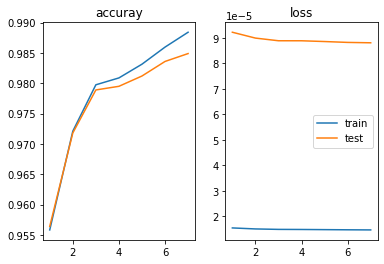

In [37]:
from matplotlib import pyplot as plt
import numpy as np

def extract(index,li):
    return [item[index] for item in li]

train_verbose_loss = extract(1,train_verbose)
test_verbose_loss = extract(1,test_verbose)
train_verbose_accuracy = extract(0,train_verbose)
test_verbose_accuray = extract(0,test_verbose)
xs = list(range(1,epochs+1))

fig,axes = plt.subplots(1,2)
axes[1].set_title('loss')
axes[0].set_title('accuray')
axes[1].plot(xs,train_verbose_loss,label='train')
axes[1].plot(xs,test_verbose_loss,label='test')
axes[0].plot(xs,train_verbose_accuracy,label='train')
axes[0].plot(xs,test_verbose_accuray,label='test')
plt.legend()
plt.show()

### Test visualization

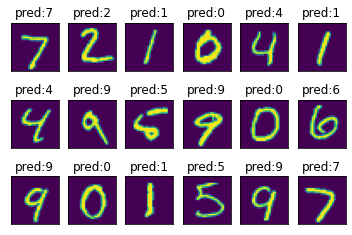

In [35]:
cnums = 6
rnums = 3
fig,axes = plt.subplots(rnums,cnums)
for i,(X,y) in enumerate(DataLoader(test_data,batch_size = 1)):
    r =int(i / cnums)
    c = i % cnums
    if r >= rnums:
        break
    axes[r][c].imshow(X.view(28,28))
    axes[r][c].get_xaxis().set_visible(False)
    axes[r][c].get_yaxis().set_visible(False)
    axes[r][c].set_title(f'pred:{model.predict(X).item()}')
plt.show()

## Conclusion

Compare to part III, the CNN model can perform better than SVM classifier.

# Part V. Semi-supervised Classification on  Cardiotocography Data Set

In [75]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [33]:
def report(model,Xttest,yttest):
    print("Model perform on test dataset")
    print("classification accuracy:", model.score(Xtest,ytest))
    print("mis-classification error:",1-model.score(Xtest,ytest))
    print("confusion matrix:\n",confusion_matrix(model.predict(Xtest),ytest))

Import all dataset and preprocess by droping NA

In [84]:
train_data_labeled = pd.read_csv("../data/CTG/CTG_Train_labeled.csv").dropna()
train_data_unlabeled = pd.read_csv("../data/CTG/CTG_Train_unlabeled.csv").dropna()
test_data = pd.read_csv("../data/CTG/CTG_Test.csv").dropna()

## 1. Try three classification methods 
using only labelled training data, and test their performances on 
the test data. Please try to optimize the tuning parameters as best as you can.  Report the results 
and conclusions.

I will use LDA, SVM, MLP in this section.

Preprocess data by using StandardScaler

In [8]:
scaler = StandardScaler()
X = scaler.fit_transform(train_data_labeled.loc[:,:"Tendency"])
y = train_data_labeled.NSP
Xtest = scaler.transform(test_data.loc[:,:"Tendency"])
ytest = test_data.NSP

### (1) LDA

In [34]:
# 1 LDA
lda = LDA()
lda.fit(X,y)

report(lda,Xtest,ytest)

Model perform on test dataset
classification accuracy: 0.8937875751503006
mis-classification error: 0.1062124248496994
confusion matrix:
 [[366  25   4]
 [ 11  46   6]
 [  3   4  34]]


### (2) SVM

In [71]:
# 2 SVM with radical kernel
params = {'C': (5, 10), 'gamma': (0.1, 0.05, 0.01)}
svms = GridSearchCV(SVC(kernel='rbf'), param_grid=params,cv=5, n_jobs=-1)
svms.fit(X, y)
pd.DataFrame({'params': svms.cv_results_[
             'params'], '5-fold CV Error': svms.cv_results_['mean_test_score']})


,params,5-fold CV Error
0,"{'C': 5, 'gamma': 0.1}",0.892
1,"{'C': 5, 'gamma': 0.05}",0.892
2,"{'C': 5, 'gamma': 0.01}",0.888
3,"{'C': 10, 'gamma': 0.1}",0.892
4,"{'C': 10, 'gamma': 0.05}",0.894
5,"{'C': 10, 'gamma': 0.01}",0.886


In [72]:
svm_best = svms.best_estimator_
svm_best

SVC(C=10, gamma=0.05)

In [73]:
report(svm_best,Xtest,ytest)

Model perform on test dataset
classification accuracy: 0.8877755511022044
mis-classification error: 0.11222444889779559
confusion matrix:
 [[360  25   2]
 [ 17  46   5]
 [  3   4  37]]


### (3) Multi-layer perceptron (MLP) algorithm

In [67]:
mlp = MLPClassifier(alpha=5e-3,learning_rate_init=1e-3,hidden_layer_sizes=(32,32), random_state=5054, max_iter=1000)
mlp.fit(X,y)

report(mlp,Xtest,ytest)

Model perform on test dataset
classification accuracy: 0.8917835671342685
mis-classification error: 0.10821643286573146
confusion matrix:
 [[363  21   3]
 [ 15  47   6]
 [  2   7  35]]


Compared to SVM and MLP, LDA perform better on the test dataset, since the other two model may be esay to overfit the train dataset and hard to tune parameter.

## 2. Try two semi-supervised classification methods 
using both labelled training data and unlabelled 
training data,  and test their performances on the test data. Please try to optimise the tuning 
parameters as best as you can.  Report the results and compare with the results using only 
labelled data. 

Preprocess train dataset

In [92]:
train_data_unlabeled['NSP'] = -1
train_data= pd.concat([train_data_labeled,train_data_unlabeled])
train_data

,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,MLTV,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
0,0.000,0.0,0.007,0.000,0.0,0.0,60.0,0.4,17.0,6.8,...,142.0,163.0,0.0,0.0,153.0,152.0,153.0,1.0,0.0,2
1,0.002,0.0,0.005,0.000,0.0,0.0,40.0,0.8,7.0,10.3,...,119.0,154.0,2.0,0.0,138.0,139.0,140.0,2.0,0.0,1
2,0.000,0.0,0.005,0.003,0.0,0.0,31.0,1.4,17.0,14.6,...,82.0,164.0,4.0,0.0,147.0,135.0,139.0,30.0,1.0,1
3,0.002,0.0,0.003,0.000,0.0,0.0,49.0,0.7,3.0,9.8,...,140.0,184.0,3.0,0.0,162.0,158.0,162.0,4.0,0.0,2
4,0.009,0.0,0.003,0.006,0.0,0.0,19.0,2.3,0.0,4.0,...,76.0,176.0,6.0,1.0,145.0,138.0,143.0,36.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1122,0.000,0.0,0.005,0.001,0.0,0.0,77.0,0.7,17.0,6.0,...,124.0,155.0,2.0,0.0,145.0,143.0,145.0,2.0,0.0,-1
1123,0.000,0.0,0.007,0.000,0.0,0.0,79.0,0.2,25.0,7.2,...,137.0,177.0,4.0,0.0,153.0,150.0,152.0,2.0,0.0,-1
1124,0.001,0.0,0.007,0.000,0.0,0.0,78.0,0.4,22.0,7.1,...,103.0,169.0,6.0,0.0,152.0,148.0,151.0,3.0,1.0,-1
1125,0.001,0.0,0.007,0.000,0.0,0.0,79.0,0.4,20.0,6.1,...,103.0,170.0,5.0,0.0,153.0,148.0,152.0,4.0,1.0,-1


In [93]:
scaler = StandardScaler()
X = scaler.fit_transform(train_data.loc[:,:"Tendency"])
y = train_data.NSP
Xtest = scaler.transform(test_data.loc[:,:"Tendency"])
ytest = test_data.NSP

### (1) KNN by SelfTraining method

In [98]:
semi_knn = SelfTrainingClassifier(KNeighborsClassifier(n_neighbors=4))
semi_knn.fit(X,y)

report(semi_knn,Xtest,ytest)

Model perform on test dataset
classification accuracy: 0.8777555110220441
mis-classification error: 0.12224448897795592
confusion matrix:
 [[374  39   6]
 [  5  32   6]
 [  1   4  32]]


### (2) SVM by SelfTraining method

In [104]:
semi_svm = SelfTrainingClassifier(
    SVC(kernel='rbf', probability=True, gamma="auto", C=10))
semi_svm.fit(X, y)

report(semi_svm, Xtest, ytest)

Model perform on test dataset
classification accuracy: 0.8837675350701403
mis-classification error: 0.11623246492985972
confusion matrix:
 [[361  27   2]
 [ 16  43   5]
 [  3   5  37]]


Both two semi-supervised classification methods perform not better than those three supervised classification methods, since the size of labeled training dataset is enough for training and shares the approximate data distribution with test dataset, so in this situation, the train dataset with unlabeled training dataset couldn't bring more value information for this classification task. Only when the size of labeled training dataset is very small and has bias on data distribution, the semi-supervised learning method can show it's advantage.